<h1>WasteWhere</h1>
This file was used for training of <strong>WasteWhere</strong> the model that classifies if an object is recyclable.<br>
We have chose transfer learning to build on the power of the Resnet model for this project.<br>


Done by Owen Tan and Ryan Ng

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [25]:
# Define data transformations for data augmentation and normalization
# making data all of same size and orientation
# .Normalize([R,G,B],Stdev)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [26]:
# Define the data directory
data_dir = 'dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [27]:
# loading the training and val datasets in mini batch size of 4 and shuffling them, also parallelizing them
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 224, 'val': 56}


['nonrecyclable', 'recyclable']

In [28]:
# load the model, freeze the layers except last layer which is the classification layer (also know as final classification layer or fully connected layer)
# after that we fine tune the model on our custom data set

# Loss: The loss function provides a feedback signal to the model, indicating how far off its predictions are from the actual values>
# EntropyLoss is the most common method to calculate loss of classification problem
# Note that the goal of the classification model is to reduce this value

# The optimizer adjusts the model's parameters iteratively, helping it converge to a point where the loss is minimized (ideally the global minimum)
# Optimizer is stochastic gradient descent optimizer
# at each iteration it helps converge where the loss is minimum

# Uses GPU if available to train the model, if not use CPU

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use these parameters to improve the model


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\ryann\anaconda3\envs\py312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ryann\anaconda3\envs\py312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# Training loop
# epoch is each cycle of training, we recommend 10 for a small dataset 
# change the num_epoch to change number of epochs

num_epochs = 10
phase_no = 0
for epoch in range(num_epochs):
    phase_no += 1
    for phase in ['train', 'val']:    # if phase is train we train, if val we evaluate
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0    # stores the loss
        running_corrects = 0  # stores number of correct predictions
        
        for inputs, labels in dataloaders[phase]:  # load the images to the device(CPU or GPU), 
            inputs = inputs.to(device)   # inputs is images
            labels = labels.to(device)

            optimizer.zero_grad() # it clear the gradients from previous iteration

            with torch.set_grad_enabled(phase == 'train'): # if phase is train we use model to make predictions
                outputs = model(inputs) # prediction is stored in output
                _, preds = torch.max(outputs, 1)  # shows the prediction
                loss = criterion(outputs, labels) # calculate loss between our label prediction and actual label

                if phase == 'train': # forward pass: we take input to model, which process image and provide corresponding label
                    loss.backward() # here we calculate the gradients 
                    optimizer.step() # and then update the weights on the basis of calculated gradients then use the forward pass to train model again

            running_loss += loss.item() * inputs.size(0) # this line and below is just vars that store all the loss and correct predictions count
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} {phase_no} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train 1 Loss: 1.9178 Acc: 0.5179
val 1 Loss: 0.4555 Acc: 0.8929
train 2 Loss: 0.5212 Acc: 0.7679
val 2 Loss: 0.2010 Acc: 0.9286
train 3 Loss: 0.4247 Acc: 0.8348
val 3 Loss: 0.1987 Acc: 0.9643
train 4 Loss: 0.3942 Acc: 0.8125
val 4 Loss: 0.1544 Acc: 0.9464
train 5 Loss: 0.3733 Acc: 0.8438
val 5 Loss: 0.0559 Acc: 0.9821
train 6 Loss: 0.3483 Acc: 0.8438
val 6 Loss: 0.0990 Acc: 0.9643
train 7 Loss: 0.5041 Acc: 0.8036
val 7 Loss: 0.0710 Acc: 0.9643
train 8 Loss: 0.5335 Acc: 0.7946
val 8 Loss: 0.0494 Acc: 0.9643
train 9 Loss: 0.3981 Acc: 0.8393
val 9 Loss: 0.1050 Acc: 0.9643
train 10 Loss: 0.3647 Acc: 0.8795
val 10 Loss: 0.0487 Acc: 1.0000
Training complete!


In [30]:
# Save the model
torch.save(model.state_dict(), 'WasteClassificationModel.pth')

<h1>Classification on Unseen Image</h1>
To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference.

In [31]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('WasteClassificationModel.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units, here we put 2 for recyclable and non-recyclable

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [32]:
# Load and preprocess the input image
image_path = 'test_image_dirty.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

Perform inference using the model:

In [33]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['nonrecyclable', 'recyclable']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: nonrecyclable


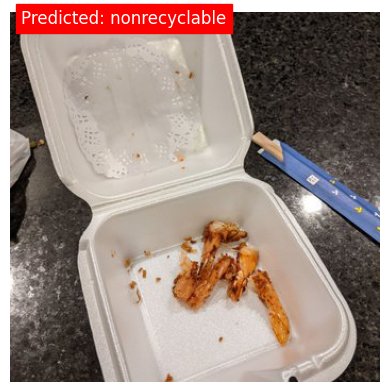

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()